# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import seaborn as sns
import json
from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression


% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#View profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [3]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [4]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


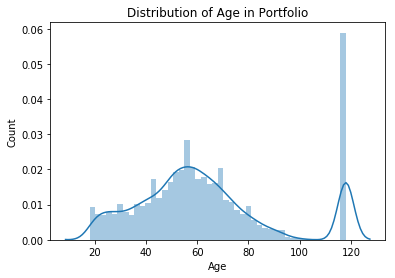

In [6]:
sns.distplot(profile['age'],hist=True)
plt.title("Distribution of Age in Portfolio")
plt.xlabel("Age")
plt.ylabel("Count");

Here we can see that for age there seems to be a large number of outliers with an age of 118. 

## Exploratory Analysis

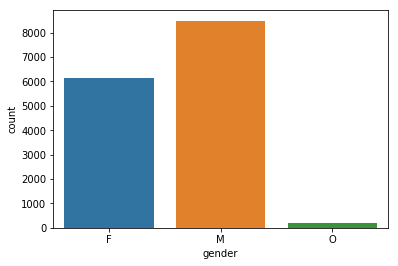

In [7]:
sns.countplot(x='gender',data=profile);

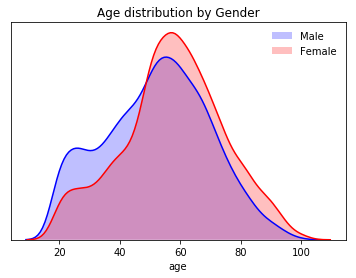

In [8]:
sns.distplot(profile[profile['gender']=='M']['age'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['age'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Age distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False);


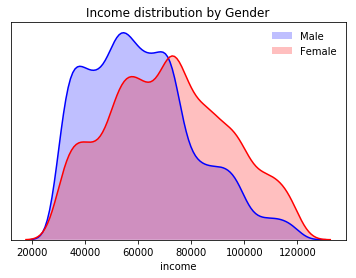

In [9]:
sns.distplot(profile[profile['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Income distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False);


## Data Processing

In [3]:
def clean_profile(profile):
    
    '''
    Function to clean profile dataframe.
    
    INPUT - Profile dataframe
    
    OUTPUT - Return cleaned version of profile dataframe
    
    '''
    
    #Convert became_member_on to datetime
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

    
    #Convert users with age 118 to np.nan
    profile['age'] = profile['age'].apply(lambda x: np.nan if x ==118 else x)
    
    #Create dummy columns for gender
    
    genders = pd.get_dummies(profile['gender'],prefix = "gender", prefix_sep = "-")
    
    profile = pd.concat([profile,genders],axis=1)
    
    #Change id column name to offer id
    
    profile.rename(columns={'id':'customer_id'},inplace=True)
    
    #Extract the number of days a user has been a member of the rewards app.
    today = pd.to_datetime(datetime.today().strftime('%Y%m%d'))
    
    
    profile['became_member_on'] = (today - profile['became_member_on']) / np.timedelta64(1,'D')
    
    
    
    return profile
    
    

profile = clean_profile(profile)
profile.head()

,age,became_member_on,gender,customer_id,income,gender-F,gender-M,gender-O
0,NaN,1371.0,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0
1,55.0,1218.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
2,NaN,856.0,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0
3,75.0,1285.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
4,NaN,1198.0,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0


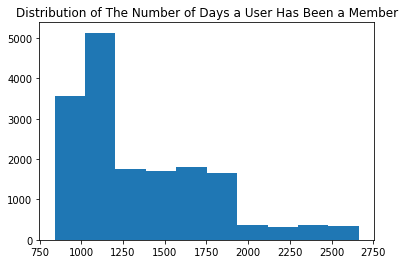

In [12]:
plt.hist(profile['became_member_on']);
plt.title('Distribution of The Number of Days a User Has Been a Member');


In [4]:
#Print mean and median for income
profile['income'].mean(), profile['income'].median()


(65404.991568296799, 64000.0)

In [5]:
#Explore portfolio
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
def clean_portfolio(portfolio):
    
    '''
    Function to clean the portoflio dataset. Encode the categorical variables.
    
    Input - Portfolio dataframe
    
    Output - Portfolio dataframe with categorical variables handled
    '''
    
    #Apply one hot encodings to channels column
    
    #Email
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    #Mobile
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    #Social
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    #Web
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    #Create dummy columns for offer_type
    offer_types = pd.get_dummies(portfolio['offer_type'], prefix ='offer_type', prefix_sep='-')
    
    portfolio = pd.concat([portfolio.drop(['offer_type','channels'],axis=1),offer_types],axis=1)
      
    portfolio.rename(columns={'id':'offer_id'},inplace=True)
    
    return portfolio
portfolio = clean_portfolio(portfolio)

In [16]:
portfolio.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,offer_type-bogo,offer_type-discount,offer_type-informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


In [17]:
#Explore transcript

transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.tail()


,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [7]:
def clean_transcript(transcript):
    
    #Extract offer_id from value column
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    
    #create two seperate columns for reward and amount
    
    for i in ['reward','amount']:
        transcript[i] = transcript['value'].apply(lambda x:x[i] if i in x else None)
    
    transcript.drop('value',axis=1,inplace=True)
    
    transcript.rename(columns={'person':'customer_id'},inplace=True)
    
    #Convert transcript time from hours to days
    transcript['time'] = transcript['time'] / 24
    
    return transcript
transcript = clean_transcript(transcript)

In [20]:
transcript.head()

,event,customer_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [21]:
#Explore transcript for one person

transcript[transcript['customer_id']=='78afa995795e4d85b5d9ceeca43f5fef']


,event,customer_id,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.50,None,NaN,19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.00,None,NaN,17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,9.25,None,NaN,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.00,None,NaN,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,15.75,None,NaN,23.93


In [8]:
def transform_transcript(transcript):
    '''
    Function to transform transcript dataframe to return a dataframe where it shows each successful and unsuccesful offer.
    
    Input - Transcript dataframe 
    
    Output - transformed transcript dataframe
     
    '''
    
    offer_customer = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    
    offer_customer.reset_index(level=[0,1],inplace = True)
    
    #Replace nan values with 0.0
    
    offer_customer.fillna(0.0, inplace = True)
    
    #Need to determine which offers where successful - where offer completed and offer viewed  are greater than 1.
    
    #We can multiply the two columns together and replace any values > 0 with 1.
    
    #This is an important step as some offers are completed but have not been viewed - meaning the offer did not cause the 
    #transaction.
    
    offer_customer['successful offer'] = offer_customer['offer completed'] * offer_customer['offer viewed']
    
    offer_customer['successful offer'] = offer_customer['successful offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    
    offer_customer.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)
                                                        
                
    return offer_customer

transcript = transform_transcript(transcript)
                    
            

In [9]:
def merge_dataframes(profile,portfolio,transcript):
    
    '''
    Function to merge all the dataframes together.
    
    Input - profile, portfolio and transcript dataframes
    
    Output - single dataframe
    
    '''
    
    overall = transcript.merge(portfolio,how='left',on='offer_id')
    
    overall = overall.merge(profile,how='left',on='customer_id')
    
    
    return overall


overall_df = merge_dataframes(profile,portfolio,transcript)

overall_df.head()

,customer_id,offer_id,successful offer,difficulty,duration,reward,email,mobile,social,web,offer_type-bogo,offer_type-discount,offer_type-informational,age,became_member_on,gender,income,gender-F,gender-M,gender-O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,10,7,2,1,1,0,1,0,1,0,33.0,1303.0,M,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,4,0,1,1,0,1,0,0,1,33.0,1303.0,M,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,3,0,1,1,1,0,0,0,1,33.0,1303.0,M,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,1,1,1,1,1,0,0,33.0,1303.0,M,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,10,10,2,1,1,1,1,0,1,0,33.0,1303.0,M,72000.0,0,1,0


We now have a single dataframe which includes information about the offer and information about the customer for every combination of offers and customers.

We also determined whether an offer was successful - which was when an offer was completed and viewed by the customer.

In [10]:
def change_offer_id(overall_df):
    
    '''
    Funtion to change the offer ids into a more readable form e.g offer 1, offer 2.
    
    Input - overall_df which is the combined dataframe from all 3 datasets.
    
    Output - overall_df with altered offer ids.
    
    '''
    
    unique_ids = list(overall_df['offer_id'].unique())
    
    for i in range(len(unique_ids)):
        
        overall_df['offer_id'] = overall_df['offer_id'].apply(lambda x: f'Offer {i+1}' if x == unique_ids[i] else x)
        
            
    return overall_df
            
overall_df = change_offer_id(overall_df)
overall_df.head()



,customer_id,offer_id,successful offer,difficulty,duration,reward,email,mobile,social,web,offer_type-bogo,offer_type-discount,offer_type-informational,age,became_member_on,gender,income,gender-F,gender-M,gender-O
0,0009655768c64bdeb2e877511632db8f,Offer 1,0.0,10,7,2,1,1,0,1,0,1,0,33.0,1303.0,M,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,Offer 2,0.0,0,4,0,1,1,0,1,0,0,1,33.0,1303.0,M,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,Offer 3,0.0,0,3,0,1,1,1,0,0,0,1,33.0,1303.0,M,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,Offer 4,1.0,5,5,5,1,1,1,1,1,0,0,33.0,1303.0,M,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,Offer 5,1.0,10,10,2,1,1,1,1,0,1,0,33.0,1303.0,M,72000.0,0,1,0


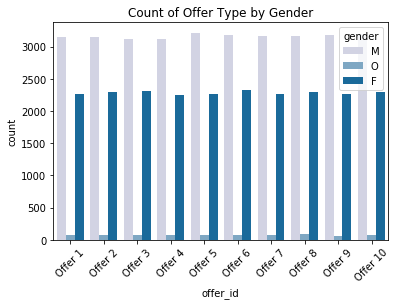

In [26]:
sns.countplot(x='offer_id',hue='gender',data=overall_df,palette='PuBu');
plt.title('Count of Offer Type by Gender')

plt.xticks(rotation=45);

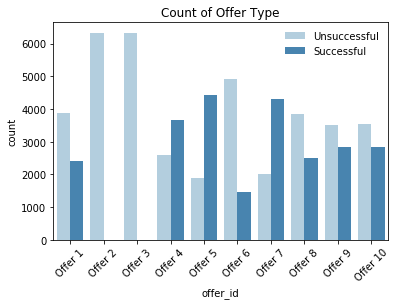

In [27]:
sns.countplot(x='offer_id',hue='successful offer',data=overall_df,palette='Blues');
plt.legend(['Unsuccessful','Successful'],frameon=False)
plt.title('Count of Offer Type')

plt.xticks(rotation=45);




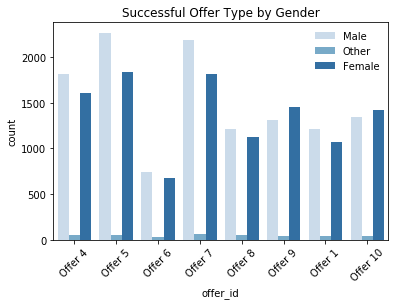

In [28]:
successful = overall_df.loc[overall_df['successful offer']==1]
sns.countplot(x='offer_id',hue='gender',data=successful,palette='Blues');
plt.legend(['Male','Other','Female'],frameon=False)
plt.title('Successful Offer Type by Gender')

plt.xticks(rotation=45);

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


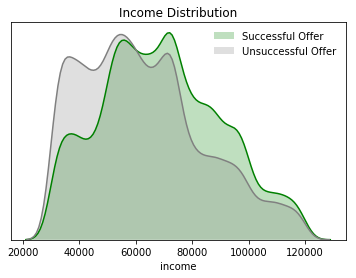

In [29]:
#Distribution of income whether offer was successful
sns.distplot(overall_df.loc[overall_df['successful offer'] == 1]['income'],hist=False,color='green',kde_kws={'shade':True})
sns.distplot(overall_df.loc[overall_df['successful offer'] == 0]['income'],hist=False,color='grey',kde_kws={'shade':True})
plt.legend(['Successful Offer', 'Unsuccessful Offer'], frameon=False)
plt.gca().get_yaxis().set_visible(False)
plt.title('Income Distribution');


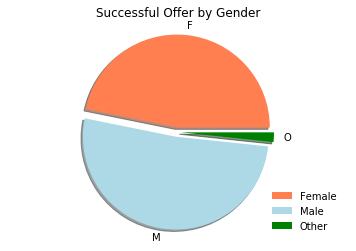

In [30]:
_ = overall_df.groupby(['gender'])['successful offer'].sum()

plt.pie(_, labels = _.index,shadow=True,explode = (0.05,0.05,0.05),colors=['coral','lightblue','green']);
plt.legend(['Female','Male','Other'],frameon=False)
plt.title("Successful Offer by Gender")

plt.gca().axis('Equal');


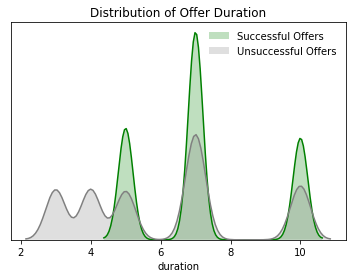

In [31]:
sns.distplot(overall_df[overall_df['successful offer']==1]['duration'],hist=False,color='green',kde_kws={'shade':True});
sns.distplot(overall_df[overall_df['successful offer']==0]['duration'],hist=False,color='grey',kde_kws={'shade':True})
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Distribution of Offer Duration')
plt.gca().get_yaxis().set_visible(False);



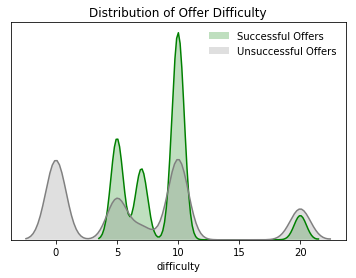

In [32]:
sns.distplot(overall_df[overall_df['successful offer']==1]['difficulty'],hist=False,color='green',kde_kws={'shade':True});
sns.distplot(overall_df[overall_df['successful offer']==0]['difficulty'],hist=False,color='grey',kde_kws={'shade':True})
plt.legend(['Successful Offers','Unsuccessful Offers'],frameon=False)
plt.title('Distribution of Offer Difficulty')
plt.gca().get_yaxis().set_visible(False);

## Modeling

Now we have performed some exploratory analysis on the datasets we can now try a few different machine learning models to try and predict which offer would be best suited for each customer.


### 1. Random Forrest Classifier

We will use an Random Forrest Classifier to try and classify and choose the offer type that would be most well received by the customer.


In [11]:


def clean_overall_df(overall_df):
    '''
    Function to clean overall_df to return X variables and the predictor Y
    
    Input - overall_df
    
    output - two dataframes X and Y
    
    X - Will be all the variables we will be using to predict the best offer type.
    
    Y - Will be the offer type.
    
    '''
    
    #We want to look at only successful offers
    
    clean_df_ = overall_df.loc[overall_df['successful offer'] == 1]
    

    
    clean_df_.drop('gender',axis=1,inplace = True)
    
    #We have missing values in income and age - fill these with the means for that column.
    
    for col in ['age','income']:
        
        clean_df_[col] = clean_df_[col].fillna(clean_df_[col].mean())
    
    
    
    
    X = clean_df_.iloc[:,3:]
    
    Y= clean_df_.iloc[:,1]
    
    
    return X, Y

X,Y = clean_overall_df(overall_df)
    
    
X.shape, Y.shape
    
    
    

((24460, 16), (24460,))

Now we have the training and test data sets we need to ensure that there are no missing values.

In [34]:
overall_df.isnull().sum()
X.isnull().sum()


difficulty                  0
duration                    0
reward                      0
email                       0
mobile                      0
social                      0
web                         0
offer_type-bogo             0
offer_type-discount         0
offer_type-informational    0
age                         0
became_member_on            0
income                      0
gender-F                    0
gender-M                    0
gender-O                    0
dtype: int64

In [35]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.25,random_state=21)
X_train.shape,X_test.shape

((18345, 16), (6115, 16))

In [36]:
#Feature scaling
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [37]:
clf = RandomForestClassifier(n_estimators=20,criterion='entropy',random_state=42)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
y_pred = clf.predict(X_test)

In [39]:
confusion = confusion_matrix(y_test,y_pred)

In [40]:
accuracy_score(y_test,y_pred)

1.0

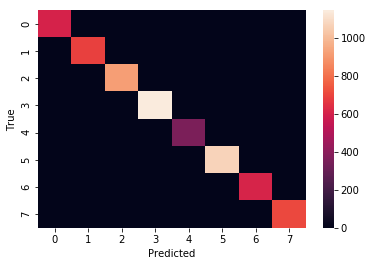

In [41]:
sns.heatmap(confusion)
plt.ylabel('True')
plt.xlabel('Predicted');

In the X dataframe used to train this model i included information about the actual offer e.g difficulty and duration. This probably explains why the classfication accuracy is so high. This is not useful as we want to be able to predict which offer would be successful using information about the customer alone.

In [42]:
X,Y = clean_overall_df(overall_df)

#Only keep inforamtion in the X dataframe that refers to the user.
X = X.iloc[:,10:]
X.head()

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2,random_state=21)

#Feature Scaling

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#Instansiate Classifier
clf = RandomForestClassifier(n_estimators=20,criterion='entropy',random_state=42)


#Train Classifier
clf.fit(X_train,y_train)





RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
y_pred = clf.predict(X_test)

print('Model accuracy: {0:0.4f}'.format(accuracy_score(y_test,y_pred)))

Model accuracy: 0.0656


In [44]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

    Offer 1       0.03      0.02      0.02       487
   Offer 10       0.03      0.03      0.03       554
    Offer 4       0.05      0.05      0.05       737
    Offer 5       0.12      0.12      0.12       909
    Offer 6       0.01      0.01      0.01       285
    Offer 7       0.11      0.12      0.11       864
    Offer 8       0.04      0.04      0.04       485
    Offer 9       0.04      0.04      0.04       571

avg / total       0.06      0.07      0.06      4892



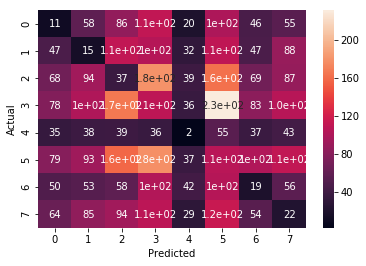

In [45]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True);
plt.xlabel("Predicted")
plt.ylabel("Actual");


## Predict whether a customer offer combination will be successful

Here we are now going to predict whether a user will complete an offer based on variables from the user and on the offer.

I will be using Logistic Regression, SVM, LDA and Adaboost to try and predict whether a customer receiving an offer will be successful.

To evaluate these models i will be using the model accuracy, the f1 score and the AUC rating. As i care equally about how the model classifies both classes i will place more of a preference on the accuracy. However, if i cared more about incorrectly classified predictions i would have chosen to focus on the f1 score. To visualize the performance of the models i will use Confusion matrixs and AUC curves.


## Logistic Regression

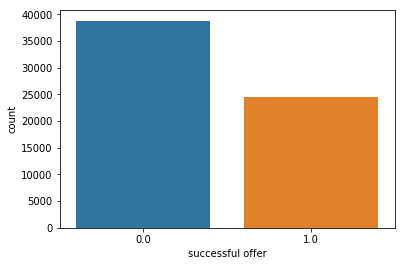

In [46]:
sns.countplot(overall_df['successful offer']);

As you can see there is a class inbalance which will effect the accuracy of the classifier. We will balance the classes by random over-sampling. So we will randomly samply datapoints from the successful offers with replacement untill we meet the number of datapoints we have for unsuccessful offers.

In [12]:
df_class1 = overall_df.loc[overall_df['successful offer']==1]

In [13]:
count_class0,count_class1 = overall_df['successful offer'].value_counts()

In [14]:
df_class1_over = df_class1.sample(count_class0,replace=True)

df_class_0 = overall_df.loc[overall_df['successful offer'] == 0]

over_df = pd.concat([df_class1_over,df_class_0],axis=0)

# over_df now has balanced classifying classes
over_df.drop('gender',axis=1,inplace=True)

### Data Preparation

Now the classes are balanced we now need to impute missing values. There are missing values in the agea and income columns. From our previous analysis there is a slight right skew in their distributions so i will inpute the missing values with the median for their respective columns.

During the initial cleaning i have already encoded the catergorical variables like gender etc.

A key assumption for Logistic Regression is that there is little or no multicolinearlity between independent variables.

In regards to outliers from my research i have read that Logistic Regression is robust in regards to outliers due to an inverse logistic loss function.

To process the data we will use MinMaxScaler.



In [15]:
over_df.isnull().sum()

#Impute missing values with median value for the column. I have chosen the median because both age and income have
#a right skew in their distributions.
for col in ['age','income']:
    over_df[col] = over_df[col].fillna(over_df[col].median())
    

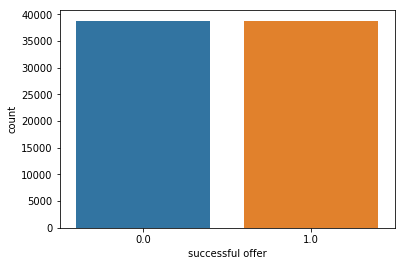

In [79]:
sns.countplot(over_df['successful offer']);

We have now rebalanced the classes via over sampling and we can now proceed to implement a classifier. But first i need to handle the offer id as it still categorical.

In [17]:
X = over_df.iloc[:,3:]
y = over_df.iloc[:,2]

X = pd.concat([X, over_df['offer_id']],axis=1)

def encode_offer_id(X):
    
    '''
    Fuction to encode offer id into dummy columns.
    
    Input - X dataframe with offer_id column present
    
    Output - X dataframe with encoded columns for offer id
    
    '''
    
    dummies = pd.get_dummies(X['offer_id'])
    
    new = pd.concat([X.drop('offer_id',axis=1), dummies],axis=1)
    
    
    return new

X = encode_offer_id(X)

X.columns

Index(['difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web',
       'offer_type-bogo', 'offer_type-discount', 'offer_type-informational',
       'age', 'became_member_on', 'income', 'gender-F', 'gender-M', 'gender-O',
       'Offer 1', 'Offer 10', 'Offer 2', 'Offer 3', 'Offer 4', 'Offer 5',
       'Offer 6', 'Offer 7', 'Offer 8', 'Offer 9'],
      dtype='object')

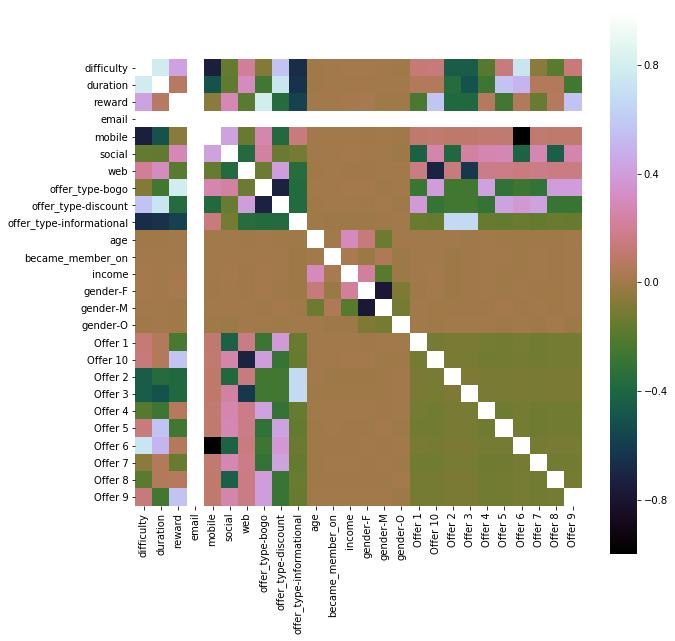

In [81]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),square=True, cmap='cubehelix');

As Logistic Regression assumes little or no multicolinearity i am going to drop the email feature as it appears to be strongly correlated with every feature.

In [102]:

X = X.drop(['email'],axis=1)

In [103]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state = 42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)


In [104]:
model = LogisticRegression(solver='liblinear',random_state=42)

In [105]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [106]:
log_pred = model.predict(X_test)

In [107]:
log_accuracy = accuracy_score(y_test,log_pred)

print("Logistic Regression Accuracy: %.2f" % accuracy_score(y_test, log_pred))

Logistic Regression Accuracy: 0.76


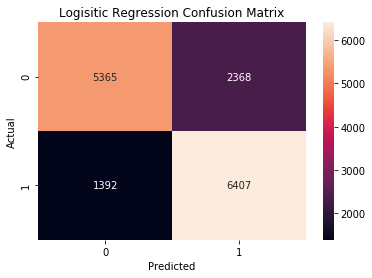

In [108]:
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='d')
plt.title('Logisitic Regression Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

In [109]:
log_f1_score = f1_score(y_test,log_pred)

print('Logisitic Regression F1 Score: %.3f' % log_f1_score)

Logisitic Regression F1 Score: 0.773


The logistic regression classifier gave an accuracy of 76% and we achieved an f1 score of 0.773. As this is a binary classifcation i will place more weight on the f1 score as the f1 score is the weighted harmonic mean of recall and precision.

Now i have just used the standard parameters I will now look at tuning the parameters with GridSeacrchCV

In [110]:
parameters = {'penalty': ['l1','l2'], 'C': [1,10,100,1000]}

grid_log = GridSearchCV(LogisticRegression(), parameters, verbose=3, n_jobs=-1,cv=3)

In [111]:
grid_log.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=1, penalty=l1 .................................................
[CV] ........................ C=1, penalty=l1, score=0.762411 -  34.9s
[CV] C=1, penalty=l1 .................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   34.9s remaining:    0.0s


[CV] ........................ C=1, penalty=l1, score=0.762073 -  36.8s
[CV] C=1, penalty=l1 .................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] ........................ C=1, penalty=l1, score=0.762749 -  33.4s
[CV] C=1, penalty=l2 .................................................
[CV] ........................ C=1, penalty=l2, score=0.762362 -   0.4s
[CV] C=1, penalty=l2 .................................................
[CV] ........................ C=1, penalty=l2, score=0.762121 -   0.4s
[CV] C=1, penalty=l2 .................................................
[CV] ........................ C=1, penalty=l2, score=0.762652 -   0.4s
[CV] C=10, penalty=l1 ................................................
[CV] ....................... C=10, penalty=l1, score=0.762459 -   0.4s
[CV] C=10, penalty=l1 ................................................
[CV] ....................... C=10, penalty=l1, score=0.761928 -   0.4s
[CV] C=10, penalty=l1 ................................................
[CV] ....................... C=10, penalty=l1, score=0.762894 -   0.4s
[CV] C=10, penalty=l2 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [112]:
grid_log.best_params_

{'C': 10, 'penalty': 'l2'}

In [113]:
log2_pred = grid_log.predict(X_test)

In [114]:
log2_accuracy = accuracy_score(y_test,log2_pred)
log2_f1 = f1_score(y_test,log2_pred)

In [115]:
print('Tuned Logistic Regression accuracy: %.3f' % log2_accuracy)
print('Tuned Logistic Regression F1 score: %.3f' % log2_f1)

Tuned Logistic Regression accuracy: 0.758
Tuned Logistic Regression F1 score: 0.773


Our original Logistic Regresion model achieved the exact same f1 score but achieved a slightly higher accuracy. So using GridSearch our model did not improve.

Typically Logistic Regression requires large samples sizes for accurate results.

## Support Vector Machines

For SVM we need to further process the data. Its important that the data is scaled to avoid difficulties in the kernel calculation. 

SVM's are great for non linear classification problems.

As using GridSearch will take too long using SVM i will change the kernel and the regularization parameter C to try and optimize the classifier.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=.2)

#Feature scaling
scaler = StandardScaler()

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)


To begin with i will use the Linear kernel and the default parameter for C, which is 1.

In [66]:

svc = SVC(kernel='linear')

#Train model
svc.fit(X_train,y_train)

#Predict values from test dataset
svc_y_pred = svc.predict(X_test)

#Evaluate accuracy and f1 score
svc_accuracy = accuracy_score(y_test,svc_y_pred)
svc_f1 = f1_score(y_test,svc_y_pred)


In [67]:
print('SVC Model Accuracy: %.3f' % svc_accuracy)
print('SVC F1 Score: %.3f' % svc_f1)

SVC Model Accuracy: 0.735
SVC F1 Score: 0.773


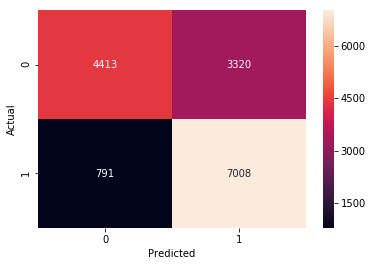

In [68]:
sns.heatmap(confusion_matrix(y_test,svc_y_pred),annot=True,fmt='d');
plt.ylabel("Actual")
plt.xlabel("Predicted");

In [69]:
print(classification_report(y_test,svc_y_pred))

             precision    recall  f1-score   support

        0.0       0.85      0.57      0.68      7733
        1.0       0.68      0.90      0.77      7799

avg / total       0.76      0.74      0.73     15532



As we have used a Linear Kernel we can view the coefficients the model has given each variable

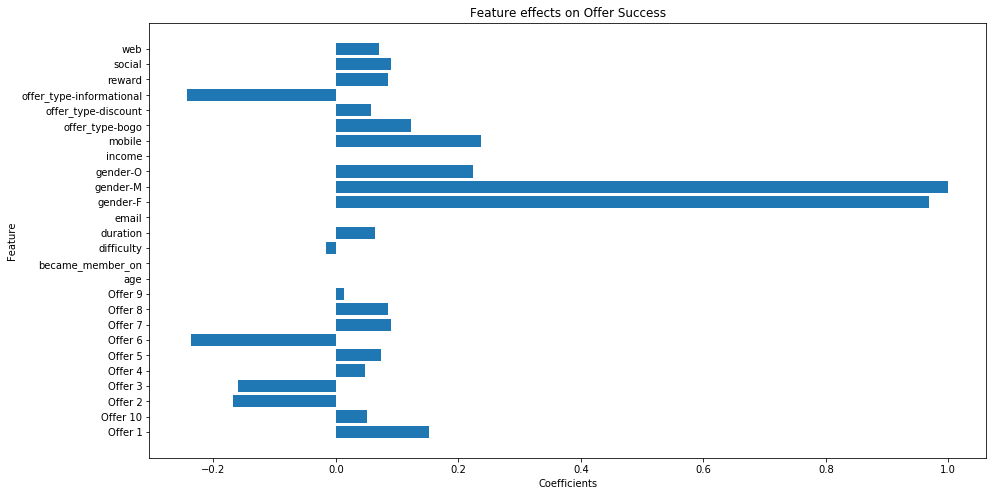

In [70]:
#Create a plot of the coefficients for a given feature.

feature_names = list(X.columns)
coefs = list(svc.coef_[0])

plt.figure(figsize=(15,8))
plt.barh(feature_names,coefs)
plt.title('Feature effects on Offer Success')
plt.xlabel('Coefficients')
plt.ylabel('Feature');



Now i will change the kernel function to Radial Basic Function.


In [71]:
svc_model = SVC(C=1,gamma=1,kernel='rbf')

svc_model.fit(X_train,y_train)




SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
y_pred_svc_2 = svc_model.predict(X_test)
svc2_accuracy = accuracy_score(y_test,y_pred_svc_2)
svc2_f1 = f1_score(y_test,y_pred_svc_2)

In [73]:
print('Accuracy for SVM with RBF Kernel: %.3f' % svc2_accuracy)
print('F1 score for SVM with RBF Kernel: %.3f' % svc2_f1)

Accuracy for SVM with RBF Kernel: 0.783
F1 score for SVM with RBF Kernel: 0.796


In [74]:
print(classification_report(y_test,y_pred_svc_2))

             precision    recall  f1-score   support

        0.0       0.82      0.72      0.77      7733
        1.0       0.75      0.84      0.80      7799

avg / total       0.79      0.78      0.78     15532



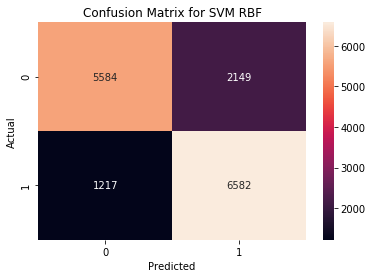

In [75]:
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test,y_pred_svc_2)

sns.heatmap(confusion_matrix(y_test,y_pred_svc_2),annot=True,fmt='d')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for SVM RBF");

In [76]:
#Area under curve
roc_auc = auc(svc_fpr,svc_tpr)
roc_auc

0.78302722182166917

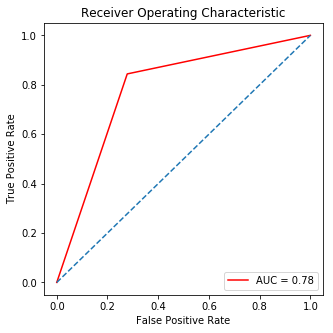

In [77]:
#Plot the auc 
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(svc_fpr,svc_tpr, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

An ideal AUC score is 1 so a score of 0.78 is not too bad, it shows that the SVC classifier is somewhat accurate in distinguising successful and unsucessful offers. After changing a few of the parameters the model achieved an accuracy of 77.8% with an F1 Score of 0.79. 

The Radial Basic Function kernel has performed better than the Linear Kernel. I will now change the C parameter to 100.



In [19]:
svc3 = SVC(C=100,gamma=1,kernel='rbf',cache_size=600)

svc3.fit(X_train,y_train)

svc3_y = svc3.predict(X_test)


In [20]:
svc3_accuracy = accuracy_score(y_test,svc3_y)
svc3_f1_score = f1_score(y_test,svc3_y)


print('SVC RBF Model with C = 100 Accuracy: %.3f' % svc3_accuracy)
print('SVC RBF Model with C = 100 F1 Score: %.3f' % svc3_f1_score)

SVC RBF Model with C = 100 Accuracy: 0.791
SVC RBF Model with C = 100 F1 Score: 0.801


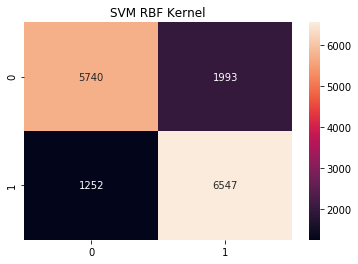

In [21]:
sns.heatmap(confusion_matrix(y_test,svc3_y),annot=True,fmt='d');
plt.title('SVM RBF Kernel');


## Linear Discriminant Analysis

We will now try to use Linear Discriminant Analysis to improve on our model accuracy. 

LDA is more sensity to outliers than the previous models. I have already examined the age of the user and removed outliers - i now need to look at income and days being a rewards member. I will use the tukey rule to remove any outliers.

LDA assumes normal distribution for features so as a preprocessing step i will normalize the data points.


In [119]:
def split_df(over_df):
    '''
    Function to split X, Y from dataframe and split into test and train datasets.
    
    Input - over_df - dataframe with classes balanced.
    
    Output - X_train, X_test, y_train, y_test
    
    '''
    
    for col in ['income','became_member_on']:
        
        #Lower quartile
        Q1 = np.percentile(over_df[col],25)
        
        #Upper quartile
        Q3 = np.percentile(over_df[col],75)
        
        #Calculate interquartile range
        IQR = Q3 - Q1
        
        #Outlier step
        step = IQR * 1.5
        
        #Remove values that are greater than the upper quartile plus 1.5 times the IQR and lower than the lower quartile 
        #minus 1.5 times the IQR.
        over_df = over_df[(over_df[col] > (Q1 - step)) & (over_df[col] < (Q3 + step))]
    
    X = over_df.iloc[:,3:]
    
   
    y = over_df.iloc[:,2]
    
    X = pd.concat([X, over_df['offer_id']],axis=1)
    
    dummies = pd.get_dummies(X['offer_id'])
    
    X = pd.concat([X.drop('offer_id',axis=1), dummies],axis=1)
    
    
    
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)
    
    return X_train, X_test, y_test, y_train


X_train, X_test, y_test, y_train = split_df(over_df)

X_train = normalize(X_train)
X_test = normalize(X_test)


In [120]:
lda = LinearDiscriminantAnalysis(solver='lsqr')

lda.fit(X_train,y_train)
y_pred = lda.predict(X_test)


In [121]:
y_pred = lda.predict(X_test)
lda_accuracy = accuracy_score(y_test,y_pred)
lda_f1 = f1_score(y_test,y_pred)

print("LDA Model Accuracy: %.3f" % lda_accuracy)
print("LDA Model F1 Accuracy: %.3f" % lda_f1)

LDA Model Accuracy: 0.765
LDA Model F1 Accuracy: 0.781


In [122]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       0.82      0.68      0.75      7636
        1.0       0.73      0.85      0.78      7517

avg / total       0.77      0.76      0.76     15153



Text(0.5,1,'LDA Confusion Matrix')

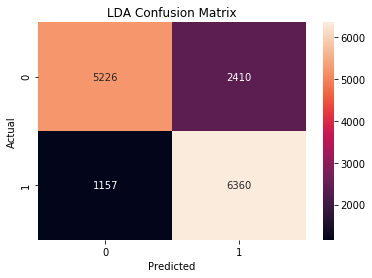

In [123]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('LDA Confusion Matrix')

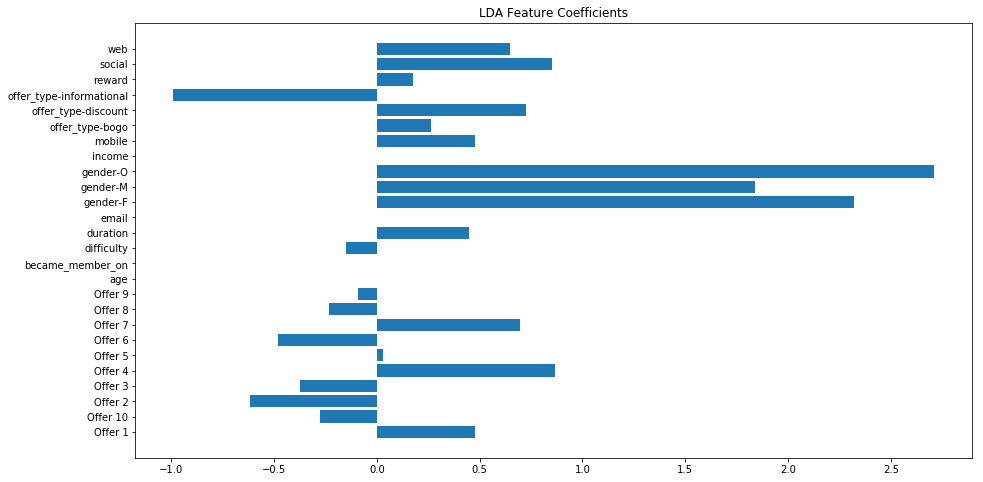

In [87]:
plt.figure(figsize=(15,8))
coefs = lda.coef_[0]
plt.barh(feature_names,coefs)
plt.title("LDA Feature Coefficients");



In [88]:
lda_fpr,lda_tpr,lda_thresholds = roc_curve(y_test,y_pred)
lda_auc = auc(lda_fpr,lda_tpr)

The LDA model did not perform as well as the SVC model but performed better than the logisitic regression model.

## Adaboost Classifier


Adaboost is a decision tree algorithm that does not require scaled data, however, it is sensitive to outliers so i will use the training dataset and test dataset where outliers have been removed.

In [89]:
parameters = {'n_estimators':[500, 1000, 1500, 2000], 
              'learning_rate':[0.05, 0.1, 0.15, 0.2]}

In [90]:
ada = AdaBoostClassifier()

clf = GridSearchCV(ada,parameters,cv=3,verbose=3,n_jobs=-1)

clf.fit(X_train,y_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] learning_rate=0.05, n_estimators=500 ............................
[CV] ... learning_rate=0.05, n_estimators=500, score=0.769372 -  18.5s
[CV] learning_rate=0.05, n_estimators=500 ............................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s


[CV] ... learning_rate=0.05, n_estimators=500, score=0.771389 -  18.0s
[CV] learning_rate=0.05, n_estimators=500 ............................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   36.5s remaining:    0.0s


[CV] ... learning_rate=0.05, n_estimators=500, score=0.766837 -  18.1s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[CV] .. learning_rate=0.05, n_estimators=1000, score=0.774518 -  36.0s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[CV] .. learning_rate=0.05, n_estimators=1000, score=0.777327 -  36.4s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[CV] .. learning_rate=0.05, n_estimators=1000, score=0.772923 -  37.1s
[CV] learning_rate=0.05, n_estimators=1500 ...........................
[CV] .. learning_rate=0.05, n_estimators=1500, score=0.775012 -  54.7s
[CV] learning_rate=0.05, n_estimators=1500 ...........................
[CV] .. learning_rate=0.05, n_estimators=1500, score=0.778366 -  54.8s
[CV] learning_rate=0.05, n_estimators=1500 ...........................
[CV] .. learning_rate=0.05, n_estimators=1500, score=0.773071 -  54.7s
[CV] learning_rate=0.05, n_estimators=2000 ...........................
[CV] .

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 36.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 1000, 1500, 2000], 'learning_rate': [0.05, 0.1, 0.15, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [91]:
clf.best_params_

{'learning_rate': 0.2, 'n_estimators': 1500}

In [101]:
ada_pred = clf.predict(X_test)
ada_accuracy = accuracy_score(y_test,ada_pred)
ada_f1 = f1_score(y_test, ada_pred)

print("ADA Model Accuracy: %.3f" % ada_accuracy)
print("ADA Model F1 Accuracy: %.3f" % ada_f1)


ADA Model Accuracy: 0.777
ADA Model F1 Accuracy: 0.789


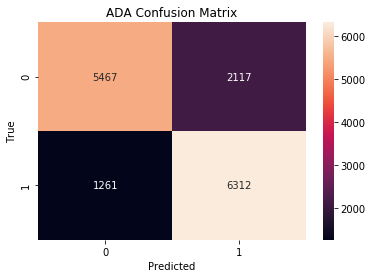

In [93]:
sns.heatmap(confusion_matrix(y_test,ada_pred),annot=True,fmt='d')
plt.title("ADA Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True');

In [95]:
print(classification_report(y_test,ada_pred))

             precision    recall  f1-score   support

        0.0       0.81      0.72      0.76      7584
        1.0       0.75      0.83      0.79      7573

avg / total       0.78      0.78      0.78     15157



In [96]:
ada_fpr,ada_tpr,ada_thresholds = roc_curve(y_test,ada_pred)
ada_auc = auc(ada_fpr,ada_tpr)

## Conclusion


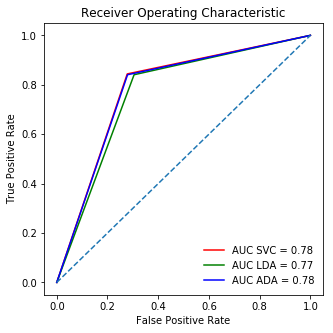

In [98]:
#Plot the auc 
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(svc_fpr,svc_tpr, color='red',label = 'AUC SVC = %0.2f' % roc_auc)
plt.plot(lda_fpr,lda_tpr,color='green',label = 'AUC LDA = %0.2f' % lda_auc)
plt.plot(ada_fpr,lda_tpr,color='blue',label='AUC ADA = %0.2f' % ada_auc)
plt.legend(loc = 'lower right',frameon=False)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

The SVM model with 'rbf' kernel produced the model with the highest accuracy, F1 score and AUC score. 

In [161]:
accuracy = np.array([log_accuracy,log2_accuracy,svc_accuracy,svc2_accuracy,svc3_accuracy,lda_accuracy,ada_accuracy]).reshape(-1,1)
f1_score = np.array([log_f1_score,log2_f1,svc_f1,svc2_f1,svc3_f1_score,lda_f1,ada_f1]).reshape(-1,1)

metrics = pd.DataFrame(np.concatenate((accuracy,f1_score),axis=1),columns=['Accuracy','F1 Score'])

model_names = np.array(['Logistic Regresson 1','Logistic Regression 2','SVC Linear','SVC RBF 1','SVC RBF 2','LDA','ADA']).reshape(-1,1)

metrics = pd.concat([metrics,pd.DataFrame(model_names)],axis=1)

metrics.columns = ['Accuracy','F1 Score','Model Names']

metrics.set_index('Model Names').sort_values(by='Accuracy',ascending=False)


,Accuracy,F1 Score
Model Names,,
SVC RBF 2,0.785218,0.795713
SVC RBF 1,0.783286,0.796370
ADA,0.777133,0.788901
LDA,0.767830,0.783459
Logistic Regression 2,0.762297,0.777992
Logistic Regresson 1,0.762168,0.777871
SVC Linear,0.735321,0.773211


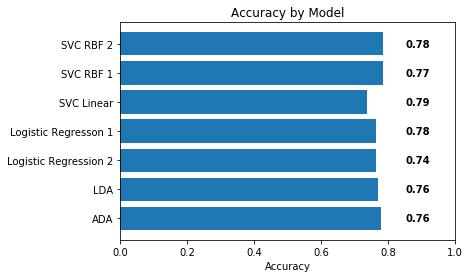

In [164]:
plt.barh(metrics['Model Names'],metrics['Accuracy']);
plt.xlabel('Accuracy')
plt.title('Accuracy by Model')
plt.xlim([0,1])


labels = ['%.2f' % x for x in metrics['Accuracy']]


for i,v in enumerate(metrics['Accuracy']):
    plt.gca().text(0.85, i - 0.1, labels[i], color='black', fontweight='bold')